In [3]:
from numpy.lib.npyio import save
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import action_selection as asl
import seaborn as sns
import pandas as pd
from scipy.stats import entropy
plt.style.use('seaborn-whitegrid')
from pandas.plotting import table

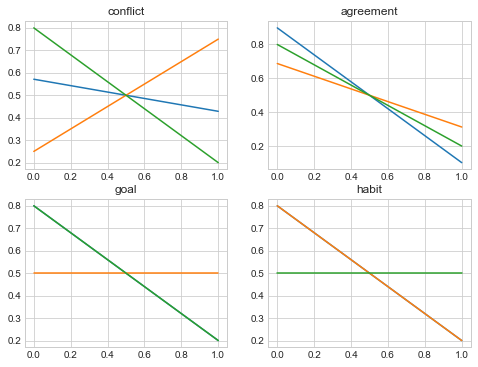

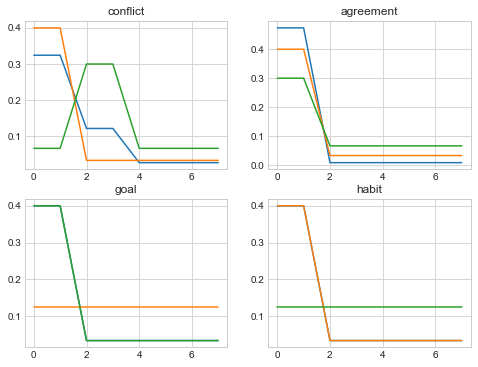

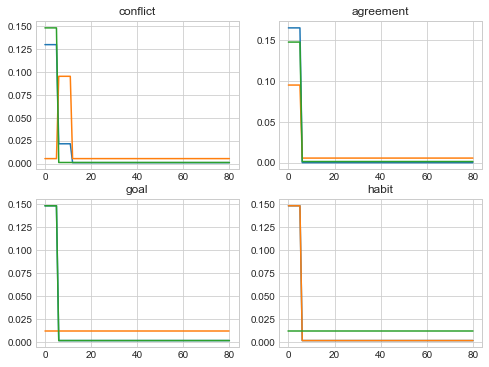

In [4]:
# DEFINE PRIORS AND LIKELIHOODDS

tests = ["conflict", "agreement", "goal", "habit"]#, "uncertainty"]
num_tests = len(tests)
test_vals = [[],[],[]]


#////////// setup 2 policies
npi = 2
flat = [1./npi]*npi

# conflict
l = [0.8,0.2]
conflict_prior = np.ones(2) - l + 0.1
conflict_prior /= conflict_prior.sum()

prior = np.array(conflict_prior)
like = np.array(l)
post = prior*like
post /= post.sum()
test_vals[0].append([post,prior,like])

# agreement
l = np.array([0.8,0.2])
agree_prior = l + 0.3
agree_prior /= agree_prior.sum()

prior = np.array(agree_prior)
like = np.array(l)
post = prior*like
post /= post.sum()
test_vals[0].append([post,prior,like])

# goal
l = [0.8,0.2]
prior = np.array(flat)
like = np.array(l)
post = prior*like
post /= post.sum()
test_vals[0].append([post,prior,like])

# habit
prior = np.array([0.8,0.2])
like = np.array(flat)
post = prior*like
post /= post.sum()
test_vals[0].append([post,prior,like])



# ///////// setup 8 policies

npi = 8
gp = 2
high_prob_1 = 0.4
high_prob_2 = 0.3
flat = np.ones(npi)/npi
h1 = np.array([high_prob_1]*gp + [(1 - high_prob_1*gp)/(npi-gp)]*(npi-gp))
h2_conf = np.array([(1 - high_prob_2*gp)/(npi-gp)]*gp + [high_prob_2]*gp + [(1 - high_prob_2*gp)/(npi-gp)]*(npi-gp*2))
h2_agree = np.array([high_prob_2]*gp + [(1 - high_prob_2*gp)/(npi-gp)]*(npi-gp))

# conflict
prior = h1.copy()
like = h2_conf.copy()
post = prior*like
post /= post.sum()
test_vals[1].append([post,prior,like])

# agreement
prior = h1.copy()
like = h2_agree.copy()
post = prior*like
post /= post.sum()
test_vals[1].append([post,prior,like])

#goal
prior = flat
like = h1.copy()
post = prior*like
post /= post.sum()
test_vals[1].append([post,prior,like])

# habit
prior = h1.copy()
like = flat
post = prior*like
post /= post.sum()
test_vals[1].append([post,prior,like])


#//// setup 81 policies
num_tests = len(tests)
gp = 6
n = 81
val = 0.148
l = [val]*gp+[(1-6*val)/(n-gp)]*(n-gp)
v = 0.00571
p = [(1-(v*(n-gp)))/6]*gp+[v]*(n-gp)
conflict = [v]*gp+[(1-(v*(n-gp)))/6]*gp+[v]*(n-2*gp)
npi = n
flat = [1./npi]*npi

# conflict
prior = np.array(conflict)
like = np.array(l)
post = prior*like
post /= post.sum()
test_vals[2].append([post,prior,like])

# agreement
prior = np.array(p)
like = np.array(l)
post = prior*like
post /= post.sum()
test_vals[2].append([post,prior,like])

# goal
prior = np.array(flat)
like = np.array(l)
post = prior*like
post /= post.sum()
test_vals[2].append([post,prior,like])

# habit
prior = np.array(l)
like = np.array(flat)
post = prior*like
post /= post.sum()
test_vals[2].append([post,prior,like])



for y in range(3):
    # print(y)
    fig, ax = plt.subplots(2,2, figsize = (8,6))
    ax = ax.reshape(ax.size)
    for i in range(4):
        ax[i].plot(test_vals[y][i][0], label='posterior')
        ax[i].plot(test_vals[y][i][1], label='prior')
        ax[i].plot(test_vals[y][i][2], label='likelihood')
        ax[i].set_title(tests[i])

    # plt.close()

In [3]:

def create_titles(mode, selector):

    if (selector.type == 'rdm'):
        fig_title = mode + ', ' + 'wd: ' + str(selector.wd) + \
                    ', ' + 's: ' + str(selector.s) + \
                    ', ' + 'b: ' + str(selector.b)
    
        file_title = mode + '_' + 'npi-' + str(npi) + \
                    '_' + 'wd-' + str(selector.wd) + \
                    '_' + 's-' + str(selector.s) + \
                    '_' + 'b-' + str(selector.b) + '.png'
        
    
    elif (selector.type == 'ardm'):
        fig_title = mode + ', ' + 'wd: ' + str(selector.wd) + \
                           ', ' + 'ws: ' + str(selector.ws) + \
                           ', ' + 's: ' + str(selector.s) + \
                           ', ' + 'b: ' + str(selector.b)

        file_title = mode + '_' + 'npi-' + str(npi) + \
                    '_' + 'wd-' + str(selector.wd) + \
                    '_' + 'ws-' + str(selector.ws) + \
                    '_' + 's-' + str(selector.s) + \
                    '_' + 'b-' + str(selector.b) + '.png'
        
    return fig_title,file_title


In [5]:
def run_action_selection(post, prior, like, selector, mode, crit_factor= 0.5, trials = 100, T = 2, plotting=False, s = 0.1, sample_posterior = False):
    
    if (selector == 'ddm'): 
        ac_sel = asl.DDM_RandomWalker(trials,T, s=s)
    elif (selector == 'rdm'):
        # def __init__ (self, trials, T, number_of_actions=2, wd = 1, s = 0.05, b = 1, A = 1, v0 = 0):
        ac_sel = asl.RacingDiffusionSelector(trials,T,s=s)
        ac_sel.sample_posterior = sample_posterior
    elif (selector == 'ardm'):
        ac_sel = asl.AdvantageRacingDiffusionSelector(trials, T)
    elif (selector == 'dirichlet'):
        ac_sel = asl.DirichletSelector(trials, 2, npi, factor=crit_factor, calc_dkl=False)
    else:
        raise ValueError('selector not given properly')
    
    # print(trials)
    actions = []

    for t in range(trials):

        if (selector == 'rdm' or selector == 'ardm'):

            actions.append(ac_sel.select_desired_action(t, 0, post, list(range(npi)), like, prior))
            # if (t%10 == 0 and (selector == 'rdm' or selector == 'ardm')):
            #     save_trajectory(mode, ac_sel, selector,t)

        elif(selector == "ddm"):

            actions.append(ac_sel.select_desired_action(t, 0, prior, like, post,True))
        else:

            ac_sel.select_desired_action(t, 0, post, list(range(npi)), like, prior, plot=plotting)
            
    return ac_sel.RT.squeeze(), ac_sel, actions

def save_trajectory(mode,selector,selector_type,t):
    plt.close()
    path = '/home/terraregina/Documents/university/MSc/habit/project/sarah_code/BalancingControl-reaction_times/' + mode + '/'
    plt.plot(selector.trajectory)
    plt.savefig(path + selector_type +'_'+'npi-'+str(npi)+'_'+mode+str(t)+'.png',dpi=100)


In [1]:
#%% RDM, 81 policies, different variances, SAMPLING FROM POSTERIOR
plt.close()
pols = [2,8,81]
for p in range(0,3):
    npi = pols[s]
    vals = np.asarray(test_vals[p])
    modes = vals.shape[0]
    RTs_overall = []
    titles = ['conflict', 'agreement', 'goal', 'habit']
    cols = ['r','g','b','k']
    alphas = [0.2,0.4, 0.7, 0.9]

    x_positions = []
    for i in range(4):
        x_positions.append([x for x in range(i*npi + i, i*npi + i + npi)])

    trials = 1000

    selector = "rdm"

    ss = [0.1,0.05, 0.03, 0.02]

    for mode in range(4):

        prior = vals[mode,1,:]
        like = vals[mode,2,:]
        post = vals[mode,0,:]

        fig,axs = plt.subplots(1,3, figsize=(10,4))
        fig.suptitle('RDM, sample from posterior ' + str(npi) + ' policies, ' + titles[mode])
        #plot rt histogram
        axs[0].plot(prior, label = "prior")
        axs[0].plot(like, label = "like")
        axs[0].plot(post, label="post")
        axs[0].legend()

        RTs = []
        for s in range(len(ss)):

            # simulate reaction times
            rt, sampler, actions = run_action_selection(post, prior, like, selector,titles[mode], trials=trials, s=ss[s], sample_posterior=True)
            # print(titles[mode])
            # print(actions)
            RTs.append(rt)

            lab = 's = ' + str(ss[s])
            axs[1].hist(rt, bins=100, label= lab,alpha=alphas[s], range=[0,400])
            axs[1].legend()

            # # plot walks
            # for i in range(len(sampler.walks)):
            #     plt.plot(range(0,len(sampler.walks[i])), sampler.walks[i])
            # plt.show()

            # plot actions and how they approximate posterior over actions
            #  had to introduce fake occurance of each action to make sure they are in there
            height = (np.bincount(actions + [x for x in range(81)]) - 1) / len(actions)

            bars = ('0', '1')

            # Choose the width of each bar and their positions
            width = [1]*81
            x_pos = x_positions[s]

            # Make the plot
            if s == 0:
                axs[2].bar(x_pos, height, width=width, alpha=0.8, label="empirical", color = 'C0')
                axs[2].bar(x_pos, post,width=width, alpha=0.5, label="post", color = 'C1')
                # axs[2].set_xticks(x_pos, bars)
                axs[2].legend()
            else:
                axs[2].bar(x_pos, height, width=width, alpha=0.8, color = 'C0')
                axs[2].bar(x_pos, post,width=width, alpha=0.5, color = 'C1')
        
            ttl = 'rdm_'+"npi-81_" + titles[mode] + '.png'

        RTs_overall.append(RTs)
        RTs = []
        plt.savefig(ttl,dpi=300)



# plot according to mode

RT_overall = np.array(RTs_overall)
alphas = [0.2,0.4, 0.7, 0.9]
alphas = [0.9, 0.7, 0.4, 0.4]
fig, ax = plt.subplots(1,4, figsize=(10,4))

m_c = 0
for rt_mode in RT_overall:

    s_c = 0
    for rt_s in rt_mode:
        ax[s_c].hist(rt_s, bins=100, alpha=alphas[m_c], range=(0,600), label=titles[m_c])
        s_c+=1
    s_c = 0
    # if(m_c == 2):
    #     break
    m_c += 1

for i in range(len(titles)):
    ax[i].title.set_text('variance = ' + str(ss[i]))
plt.legend()
plt.savefig('rdm_npi-81_combined.png', dpi=300)

NameError: name 'plt' is not defined

walk finished
walk finished
walk finished
walk finished
walk finished
walk finished
walk finished
walk finished


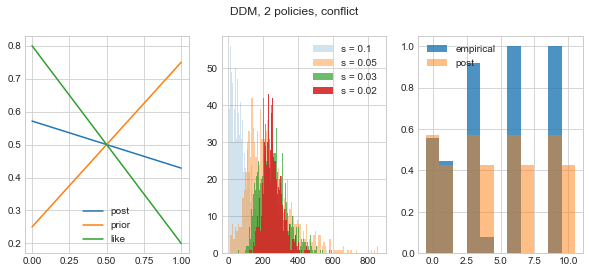

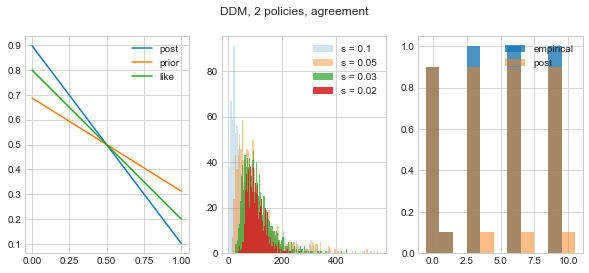

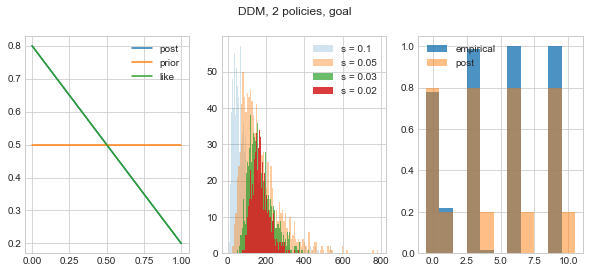

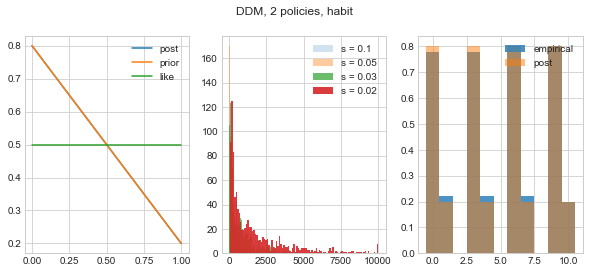

In [32]:
#%% DDM, 2 policies, different variances
plt.close()
vals = np.asarray(test_vals[0])
modes = vals.shape[0]
RTs_overall = []
titles = ['conflict', 'agreement', 'goal', 'habit']
cols = ['r','g','b','k']
alphas = [0.2,0.4, 0.7, 0.9]
x_positions = [[0,1],[3,4], [6,7], [9,10]]
trials = 1000

selector = "ddm"

ss = [0.1,0.05, 0.03, 0.02]
for mode in range(4):

    post = vals[mode,0,:]
    prior = vals[mode,1,:]
    like = vals[mode,2,:]

    fig,axs = plt.subplots(1,3, figsize=(10,4))
    fig.suptitle('DDM, 2 policies, ' + titles[mode])
    #plot rt histogram
    axs[0].plot(post, label="post")
    axs[0].plot(prior, label = "prior")
    axs[0].plot(like, label = "like")
    axs[0].legend()

    RTs = []
    for s in range(len(ss)):
        # simulate reaction times

        rt, sampler, actions = run_action_selection(post, prior, like, selector,titles[mode], trials=trials, s=ss[s])
        # print(titles[mode])
        # print(actions)
        RTs.append(rt)

        lab = 's = ' + str(ss[s])
        axs[1].hist(rt, bins=100, label= lab,alpha=alphas[s])
        axs[1].legend()

        # # plot walks
        # for i in range(len(sampler.walks)):
        #     plt.plot(range(0,len(sampler.walks[i])), sampler.walks[i])
        # plt.show()

        # plot actions and how they approximate posterior over actions

        height = np.asarray([trials - np.asarray(actions).sum(), np.asarray(actions).sum()])/trials
        bars = ('0', '1')

        # Choose the width of each bar and their positions
        width = [1,1]
        x_pos = x_positions[s]
        # Make the plot
        if s == 0:
            axs[2].bar(x_pos, height, width=width, alpha=0.8, label="empirical", color = 'C0')
            axs[2].bar(x_pos, post,width=width, alpha=0.5, label="post", color = 'C1')
            # axs[2].set_xticks(x_pos, bars)
            axs[2].legend()
        else:
            axs[2].bar(x_pos, height, width=width, alpha=0.8, color = 'C0')
            axs[2].bar(x_pos, post,width=width, alpha=0.5, color = 'C1')
    
        ttl = 'ddm_'+"npi-2_" + titles[mode] + '.png'

    RTs_overall.append(RTs)
    RTs = []
    # plt.savefig(ttl,dpi=300)



# compare different regimes

RT_overall = np.array(RTs_overall)
alphas = [0.2,0.4, 0.7, 0.9]
alphas = [0.9, 0.7, 0.4, 0.4]
fig, ax = plt.subplots(1,4, figsize=(10,4))

m_c = 0
for rt_mode in RT_overall:

    s_c = 0
    for rt_s in rt_mode:
        ax[s_c].hist(rt_s, bins=100, alpha=alphas[m_c], range=(0,1000), label=titles[m_c])
        s_c+=1
    s_c = 0
    # if(m_c == 2):
    #     break
    m_c += 1

for i in range(len(titles)):
    ax[i].title.set_text('variance = ' + str(ss[i]))
plt.legend()
plt.savefig('ddm_npi-2_combined.png', dpi=300)

Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at th

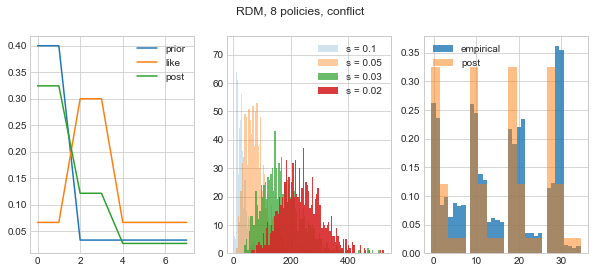

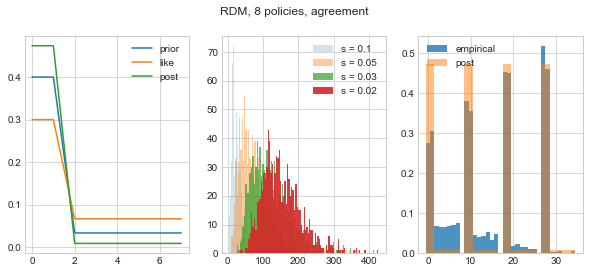

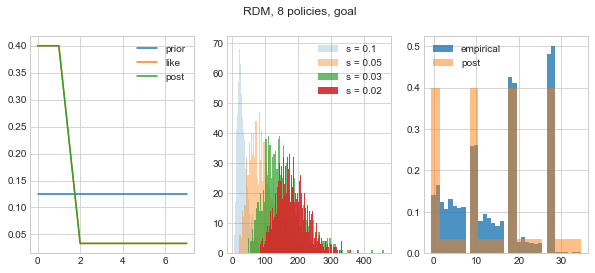

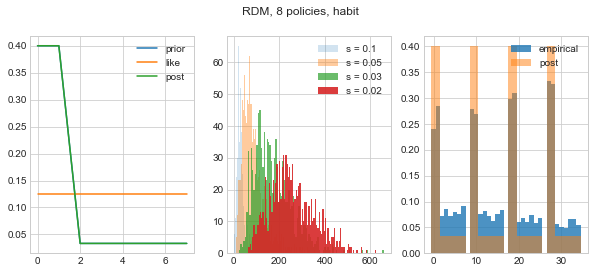

In [119]:
#%% RDM, 8 policies, different variances
plt.close()
vals = np.asarray(test_vals[1])
modes = vals.shape[0]
RTs_overall = []
titles = ['conflict', 'agreement', 'goal', 'habit']
cols = ['r','g','b','k']
alphas = [0.2,0.4, 0.7, 0.9]
x_positions = [[0,1,2,3,4,5,6,7],[9,10,11,12,13,14,15,16], [18,19,20,21,22,23,24,25], [27,28,29,30,31,32,33,34]]
trials = 1000

selector = "rdm"

ss = [0.1,0.05, 0.03, 0.02]
for mode in range(4):

    post = vals[mode,0,:]
    prior = vals[mode,1,:]
    like = vals[mode,2,:]

    fig,axs = plt.subplots(1,3, figsize=(10,4))
    fig.suptitle('RDM, 8 policies, ' + titles[mode])
    #plot rt histogram
    axs[0].plot(prior, label = "prior")
    axs[0].plot(like, label = "like")
    axs[0].plot(post, label="post")
    axs[0].legend()

    RTs = []
    for s in range(len(ss)):
    # for s in range(1):
        # simulate reaction times

        rt, sampler, actions = run_action_selection(post, prior, like, selector,titles[mode], trials=trials, s=ss[s])
        print(actions)
        # print(titles[mode])
        # print(actions)
        RTs.append(rt)

        lab = 's = ' + str(ss[s])
        axs[1].hist(rt, bins=100, label= lab,alpha=alphas[s])
        axs[1].legend()

        # # plot walks
        # for i in range(len(sampler.walks)):
        #     plt.plot(range(0,len(sampler.walks[i])), sampler.walks[i])
        # plt.show()

        # plot actions and how they approximate posterior over actions
        #  had to introduce fake occurance of each action to make sure they are in there
        height = (np.bincount(actions + [x for x in range(8)]) - 1) / len(actions)

        bars = ('0', '1')

        # Choose the width of each bar and their positions
        width = [1,1,1,1,1,1,1,1]
        x_pos = x_positions[s]
        # Make the plot
        if s == 0:
            axs[2].bar(x_pos, height, width=width, alpha=0.8, label="empirical", color = 'C0')
            axs[2].bar(x_pos, post,width=width, alpha=0.5, label="post", color = 'C1')
            # axs[2].set_xticks(x_pos, bars)
            axs[2].legend()
        else:
            axs[2].bar(x_pos, height, width=width, alpha=0.8, color = 'C0')
            axs[2].bar(x_pos, post,width=width, alpha=0.5, color = 'C1')
    
        ttl = 'rdm_'+"npi-8_" + titles[mode] + '.png'

    RTs_overall.append(RTs)
    RTs = []
    plt.savefig(ttl,dpi=300)



# plot according to mode

RT_overall = np.array(RTs_overall)
alphas = [0.2,0.4, 0.7, 0.9]
alphas = [0.9, 0.7, 0.4, 0.4]
fig, ax = plt.subplots(1,4, figsize=(10,4))

m_c = 0
for rt_mode in RT_overall:

    s_c = 0
    for rt_s in rt_mode:
        ax[s_c].hist(rt_s, bins=100, alpha=alphas[m_c], range=(0,600), label=titles[m_c])
        s_c+=1
    s_c = 0
    # if(m_c == 2):
    #     break
    m_c += 1

for i in range(len(titles)):
    ax[i].title.set_text('variance = ' + str(ss[i]))
plt.legend()
plt.savefig('rdm_npi-8_combined.png', dpi=300)

Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at th

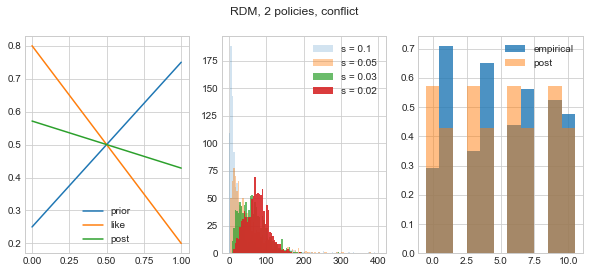

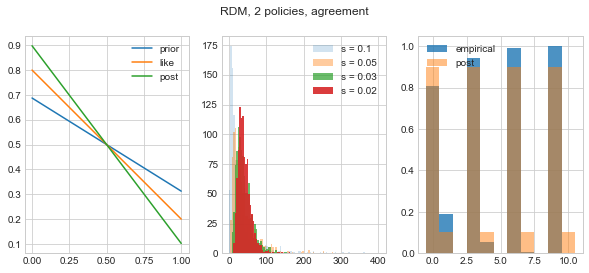

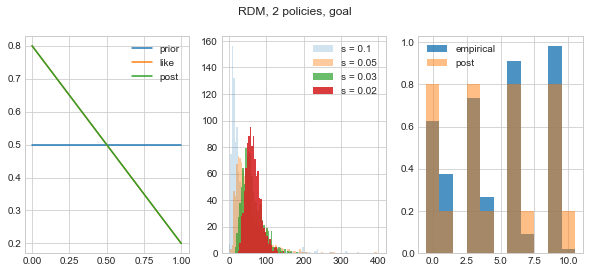

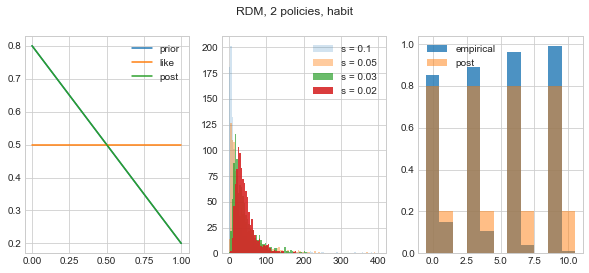

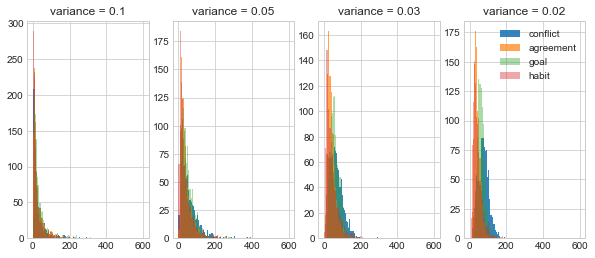

In [6]:
#%% RDM, 2 policies, different variances
plt.close()
vals = np.asarray(test_vals[0])
modes = vals.shape[0]
RTs_overall = []
titles = ['conflict', 'agreement', 'goal', 'habit']
cols = ['r','g','b','k']
alphas = [0.2,0.4, 0.7, 0.9]
x_positions = [[0,1],[3,4], [6,7], [9,10]]
trials = 1000

selector = "rdm"

ss = [0.1,0.05, 0.03, 0.02]
for mode in range(4):

    post = vals[mode,0,:]
    prior = vals[mode,1,:]
    like = vals[mode,2,:]

    fig,axs = plt.subplots(1,3, figsize=(10,4))
    fig.suptitle('RDM, 2 policies, ' + titles[mode])
    #plot rt histogram
    axs[0].plot(prior, label = "prior")
    axs[0].plot(like, label = "like")
    axs[0].plot(post, label="post")
    axs[0].legend()

    RTs = []
    for s in range(len(ss)):
    # for s in range(1):
        # simulate reaction times

        rt, sampler, actions = run_action_selection(post, prior, like, selector,titles[mode], trials=trials, s=ss[s])
        # print(titles[mode])
        # print(actions)
        RTs.append(rt)

        lab = 's = ' + str(ss[s])
        axs[1].hist(rt, bins=100, label= lab,alpha=alphas[s], range=[0,400])
        axs[1].legend()

        # # plot walks
        # for i in range(len(sampler.walks)):
        #     plt.plot(range(0,len(sampler.walks[i])), sampler.walks[i])
        # plt.show()

        # plot actions and how they approximate posterior over actions
        #  had to introduce fake occurance of each action to make sure they are in there
        height = (np.bincount(actions + [x for x in range(2)]) - 1) / len(actions)

        bars = ('0', '1')

        # Choose the width of each bar and their positions
        width = [1,1]
        x_pos = x_positions[s]
        # Make the plot
        if s == 0:
            axs[2].bar(x_pos, height, width=width, alpha=0.8, label="empirical", color = 'C0')
            axs[2].bar(x_pos, post,width=width, alpha=0.5, label="post", color = 'C1')
            # axs[2].set_xticks(x_pos, bars)
            axs[2].legend()
        else:
            axs[2].bar(x_pos, height, width=width, alpha=0.8, color = 'C0')
            axs[2].bar(x_pos, post,width=width, alpha=0.5, color = 'C1')
    
        ttl = 'rdm_'+"npi-2_" + titles[mode] + '.png'

    RTs_overall.append(RTs)
    RTs = []
    plt.savefig(ttl,dpi=300)



# plot according to mode

RT_overall = np.array(RTs_overall)
alphas = [0.2,0.4, 0.7, 0.9]
alphas = [0.9, 0.7, 0.4, 0.4]
fig, ax = plt.subplots(1,4, figsize=(10,4))

m_c = 0
for rt_mode in RT_overall:

    s_c = 0
    for rt_s in rt_mode:
        ax[s_c].hist(rt_s, bins=100, alpha=alphas[m_c], range=(0,600), label=titles[m_c])
        s_c+=1
    s_c = 0
    # if(m_c == 2):
    #     break
    m_c += 1

for i in range(len(titles)):
    ax[i].title.set_text('variance = ' + str(ss[i]))
plt.legend()
plt.savefig('rdm_npi-8_combined.png', dpi=300)

Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at the same time, choosing one at random
Two integrators crossed boundary at th

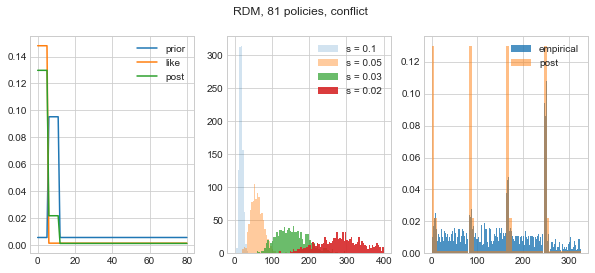

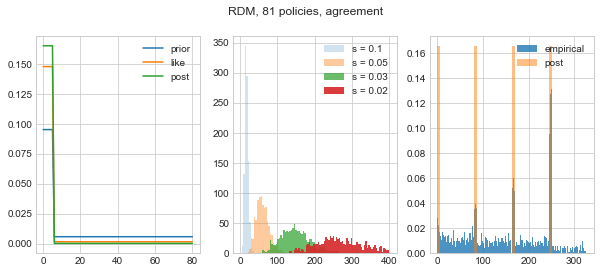

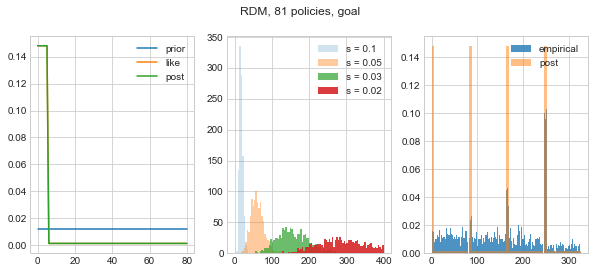

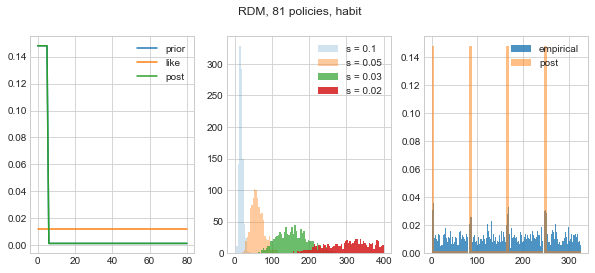

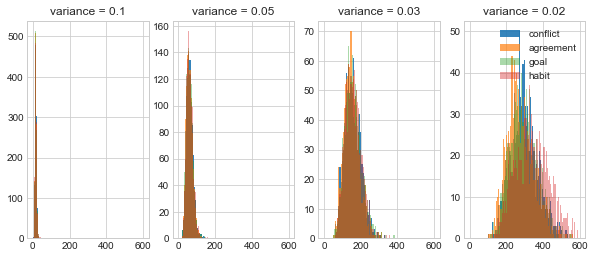

In [37]:
#%% RDM, 81 policies, different variances
plt.close()
vals = np.asarray(test_vals[2])
modes = vals.shape[0]
RTs_overall = []
titles = ['conflict', 'agreement', 'goal', 'habit']
cols = ['r','g','b','k']
alphas = [0.2,0.4, 0.7, 0.9]

x_positions = []
for i in range(4):
    x_positions.append([x for x in range(i*81 + i, i*81 + i + 81)])

trials = 1000

selector = "rdm"

ss = [0.1,0.05, 0.03, 0.02]
for mode in range(4):

    prior = vals[mode,1,:]
    like = vals[mode,2,:]
    post = vals[mode,0,:]

    fig,axs = plt.subplots(1,3, figsize=(10,4))
    fig.suptitle('RDM, 81 policies, ' + titles[mode])
    #plot rt histogram
    axs[0].plot(prior, label = "prior")
    axs[0].plot(like, label = "like")
    axs[0].plot(post, label="post")
    axs[0].legend()

    RTs = []
    for s in range(len(ss)):
    # for s in range(1):
        # simulate reaction times

        rt, sampler, actions = run_action_selection(post, prior, like, selector,titles[mode], trials=trials, s=ss[s])
        # print(titles[mode])
        # print(actions)
        RTs.append(rt)

        lab = 's = ' + str(ss[s])
        axs[1].hist(rt, bins=100, label= lab,alpha=alphas[s], range=[0,400])
        axs[1].legend()

        # # plot walks
        # for i in range(len(sampler.walks)):
        #     plt.plot(range(0,len(sampler.walks[i])), sampler.walks[i])
        # plt.show()

        # plot actions and how they approximate posterior over actions
        #  had to introduce fake occurance of each action to make sure they are in there
        height = (np.bincount(actions + [x for x in range(81)]) - 1) / len(actions)

        bars = ('0', '1')

        # Choose the width of each bar and their positions
        width = [1]*81
        x_pos = x_positions[s]

        # Make the plot
        if s == 0:
            axs[2].bar(x_pos, height, width=width, alpha=0.8, label="empirical", color = 'C0')
            axs[2].bar(x_pos, post,width=width, alpha=0.5, label="post", color = 'C1')
            # axs[2].set_xticks(x_pos, bars)
            axs[2].legend()
        else:
            axs[2].bar(x_pos, height, width=width, alpha=0.8, color = 'C0')
            axs[2].bar(x_pos, post,width=width, alpha=0.5, color = 'C1')
    
        ttl = 'rdm_'+"npi-81_" + titles[mode] + '.png'

    RTs_overall.append(RTs)
    RTs = []
    plt.savefig(ttl,dpi=300)



# plot according to mode

RT_overall = np.array(RTs_overall)
alphas = [0.2,0.4, 0.7, 0.9]
alphas = [0.9, 0.7, 0.4, 0.4]
fig, ax = plt.subplots(1,4, figsize=(10,4))

m_c = 0
for rt_mode in RT_overall:

    s_c = 0
    for rt_s in rt_mode:
        ax[s_c].hist(rt_s, bins=100, alpha=alphas[m_c], range=(0,600), label=titles[m_c])
        s_c+=1
    s_c = 0
    # if(m_c == 2):
    #     break
    m_c += 1

for i in range(len(titles)):
    ax[i].title.set_text('variance = ' + str(ss[i]))
plt.legend()
plt.savefig('rdm_npi-81_combined.png', dpi=300)

In [36]:
x_pos


[9, 10]

In [ ]:
# # #%% Simulation with DDM 2 policies

# vals = np.asarray(test_vals[0])
# modes = vals.shape[0]
# RTs = []
# titles = ['conflict', 'agreement', 'goal', 'habit']
# cols = ['r','g','b','k']
# trials = 1000
# plt.figure()
# selector = "ddm"
# plt.close()

# for mode in range(4):
#     # simulate reaction times
#     post = vals[mode,0,:]
#     prior = vals[mode,1,:]
#     like = vals[mode,2,:]
#     rt, sampler, actions = run_action_selection(post, prior, like, selector,titles[mode], trials=trials)

#     RTs.append(rt)

#     fig,axs = plt.subplots(1,3, figsize=(7,4))
    
#     #plot rt histogram
#     axs[0].plot(post, label="post")
#     axs[0].plot(prior, label = "prior")
#     axs[0].plot(like, label = "like")
#     axs[0].legend()

#     axs[1].hist(rt, bins=100, label=titles[mode], color=cols[mode])
#     axs[1].legend()

#     # # plot walks
#     # for i in range(len(sampler.walks)):
#     #     plt.plot(range(0,len(sampler.walks[i])), sampler.walks[i])
#     # plt.show()

#     # plot actions and how they approximate posterior over actions

#     height = np.asarray([trials - np.asarray(actions).sum(), np.asarray(actions).sum()])/trials
#     bars = ('0', '1')

#     # Choose the width of each bar and their positions
#     width = [1,1]
#     x_pos = [0,1]
    
#     # Make the plot
#     axs[2].bar(x_pos, height, width=width, alpha=0.8, label="empirical")
#     axs[2].bar(x_pos, post,width=width, alpha=0.5, label="post")
#     # axs[2].set_xticks(x_pos, bars)
#     axs[2].legend()
#     ttl = 'ddm_'+"npi-2_" + titles[mode] + '.png'
#     plt.savefig(ttl)
